In [3]:
!pip install opencv-python


In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


In [5]:
dataset_path = "dataset"


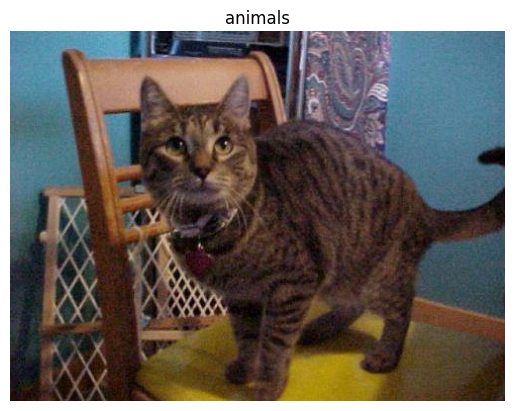

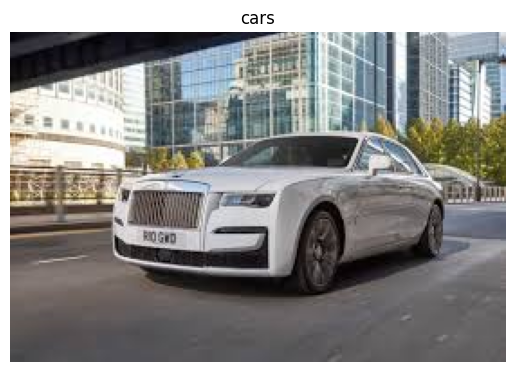

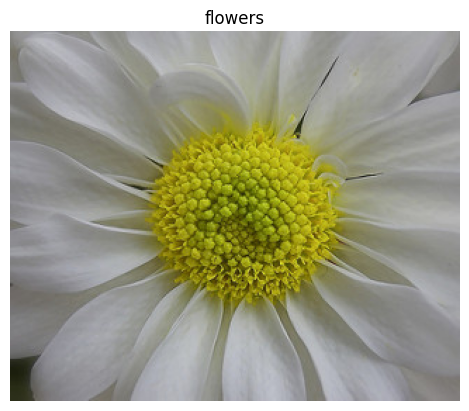

In [6]:
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    img_name = os.listdir(cls_path)[0]
    img_path = os.path.join(cls_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
    plt.show()


DEFINE PREPROCESSING FUNCTION

In [7]:
def preprocess_image(img_path, size=(128, 128)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img


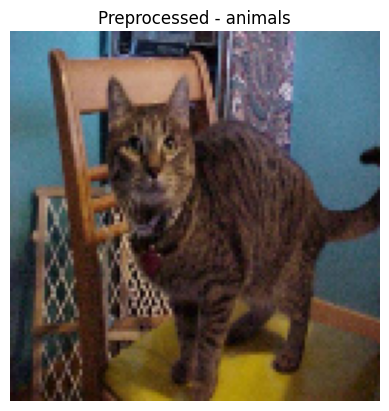

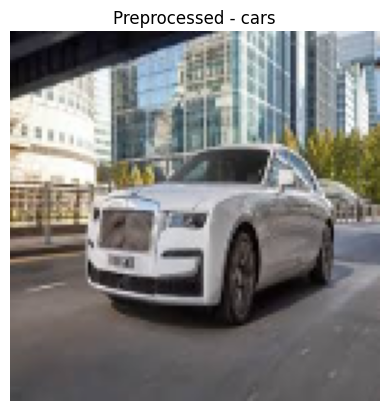

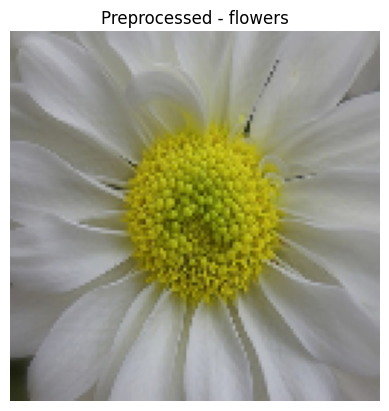

In [8]:
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    img_name = os.listdir(cls_path)[0]
    img_path = os.path.join(cls_path, img_name)

    img = preprocess_image(img_path)

    plt.imshow(img)
    plt.title(f"Preprocessed - {cls}")
    plt.axis("off")
    plt.show()


CONVERT IMAGE TO GRAYSCALE

In [9]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [10]:
def divide_into_blocks(gray_img, block_size=8):
    h, w = gray_img.shape
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = gray_img[i:i+block_size, j:j+block_size]
            if block.shape == (block_size, block_size):
                blocks.append(block)
    return blocks


In [11]:
def odbtc_block(block):
    mean_val = block.mean()
    bitmap = (block >= mean_val).astype(np.uint8)

    high_mean = block[bitmap == 1].mean() if np.any(bitmap == 1) else mean_val
    low_mean = block[bitmap == 0].mean() if np.any(bitmap == 0) else mean_val

    return bitmap, high_mean, low_mean


In [12]:
def apply_odbtc(img):
    gray = to_grayscale(img)
    blocks = divide_into_blocks(gray)

    bitmaps = []
    high_means = []
    low_means = []

    for block in blocks:
        bitmap, h, l = odbtc_block(block)
        bitmaps.append(bitmap)
        high_means.append(h)
        low_means.append(l)

    return bitmaps, high_means, low_means


TEST ODBC

In [13]:
cls = os.listdir(dataset_path)[0]
img_name = os.listdir(os.path.join(dataset_path, cls))[0]
img_path = os.path.join(dataset_path, cls, img_name)

img = preprocess_image(img_path)

bitmaps, highs, lows = apply_odbtc(img)

print("Number of blocks:", len(bitmaps))
print("Sample High Mean:", highs[0])
print("Sample Low Mean:", lows[0])


Number of blocks: 256
Sample High Mean: 130.25
Sample Low Mean: 125.03125


BIT PATTERN FEATURE (BPF)

In [14]:
def extract_bpf(bitmaps):
    return np.concatenate([bitmap.flatten() for bitmap in bitmaps])


COLOR CO-OCCURRENCE FEATURE (CCF)

In [15]:
def extract_ccf(high_means, low_means):
    return np.array([
        np.mean(high_means),
        np.std(high_means),
        np.mean(low_means),
        np.std(low_means)
    ])


FINAL FEATURE VECTOR(feature extraction)

In [16]:
def extract_features(img):
    bitmaps, high_means, low_means = apply_odbtc(img)
    bpf = extract_bpf(bitmaps)
    ccf = extract_ccf(high_means, low_means)
    return np.concatenate((bpf, ccf))


In [17]:
feature_vector = extract_features(img)
print("Feature vector length:", feature_vector.shape[0])


Feature vector length: 16388


INITIALIZE DATABASE VARIABLES

In [18]:
feature_database = []
image_paths = []
image_labels = []


In [19]:
dataset_path = "dataset"
MAX_IMAGES_PER_CLASS = 60   # keep 50–80 for fast execution

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    count = 0
    for file in os.listdir(cls_path):
        if count >= MAX_IMAGES_PER_CLASS:
            break

        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(cls_path, file)
            img = preprocess_image(img_path)

            if img is None:
                continue

            feature_vector = extract_features(img)

            feature_database.append(feature_vector)
            image_paths.append(img_path)
            image_labels.append(cls)

            count += 1

    print(f"Indexed {count} images from class '{cls}'")


Indexed 60 images from class 'animals'
Indexed 60 images from class 'cars'
Indexed 60 images from class 'flowers'


In [20]:
feature_database = np.array(feature_database, dtype=object)
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)


In [21]:
os.makedirs("features", exist_ok=True)

np.save("features/feature_database.npy", feature_database)
np.save("features/image_paths.npy", image_paths)
np.save("features/image_labels.npy", image_labels)

print("Feature database saved successfully.")


Feature database saved successfully.


In [22]:
print("Total images indexed:", len(feature_database))
print("Feature vector length:", feature_database[0].shape[0])
print("Sample label:", image_labels[0])


Total images indexed: 180
Feature vector length: 16388
Sample label: animals


LOAD SAVED FEATURE DATABASE

In [23]:
feature_database = np.load("features/feature_database.npy", allow_pickle=True)
image_paths = np.load("features/image_paths.npy", allow_pickle=True)
image_labels = np.load("features/image_labels.npy", allow_pickle=True)


pick query image

In [42]:
query_image_path = image_paths[8]  

In [64]:
query_img = preprocess_image(r"C:\Users\Admin\Desktop\CBIR\dataset\flowers\12240303_80d87f77a3_n.jpg")


In [65]:
query_feature = extract_features(query_img)
print("Query feature length:", query_feature.shape[0])


Query feature length: 16388


In [66]:
feature_database = np.array(feature_database, dtype=np.float32)
query_feature = np.array(query_feature, dtype=np.float32).flatten()

distances = np.linalg.norm(feature_database - query_feature, axis=1)


In [67]:
TOP_K = 5
top_indices = np.argsort(distances)[:TOP_K]


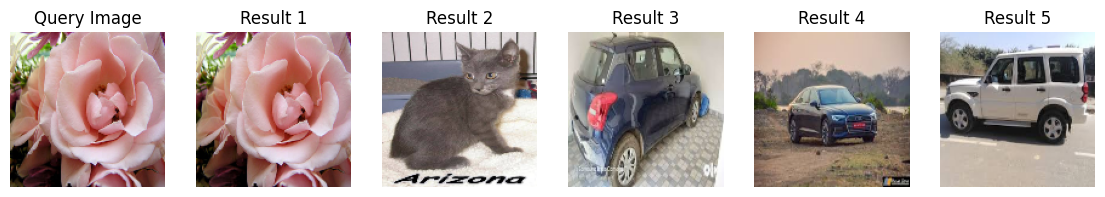

In [68]:
plt.figure(figsize=(14,4))

plt.subplot(1, TOP_K + 1, 1)
plt.imshow(query_img)
plt.title("Query Image")
plt.axis("off")

for i, idx in enumerate(top_indices):
    img = preprocess_image(image_paths[idx])
    plt.subplot(1, TOP_K + 1, i + 2)
    plt.imshow(img)
    plt.title(f"Result {i+1}")
    plt.axis("off")

plt.show()
